**DATA UNDERSTANDING AND PREPARATION**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [3]:
# import data set
df = pd.read_csv('C:/Users/zanin/OneDrive/Área de Trabalho/airbnbrj/listingsrj.csv')
df_cal = pd.read_csv('C:/Users/zanin/OneDrive/Área de Trabalho/airbnbrj/calendar.csv')

# Identify the numer of rows and columns in the dataset

for data in [df, df_cal]:
    print(data.shape)


(26366, 75)
(9623164, 7)


In [4]:
# columns will all value as NaN(null) is useless to our analysis and can't be filled with any reference value in the column.
# Removing the columns which has all values NaN(null).
df.dropna(axis=1, how='all', inplace=True)
df.shape

(26366, 71)

Variables of interest: Price or Price per accomodation?



In [5]:
# remove money ($) sign and convert to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['price'].fillna(df['price'].median(), inplace = True)


<AxesSubplot: xlabel='price'>

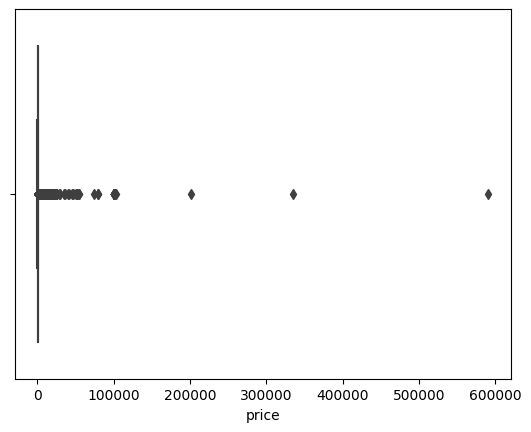

In [6]:
#showing on the box plot listings with extremely outliers price
sns.boxplot(data=df, x='price')

In [7]:
# As we could see on the boxplot above there are a few outliers that couse a bid distortion on the analyse, for that i decide to remove them using IQR to make a better view of the whole
#  removing outliers in price to better analize and visualize the data.
cols = ['price'] 
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

<AxesSubplot: xlabel='price'>

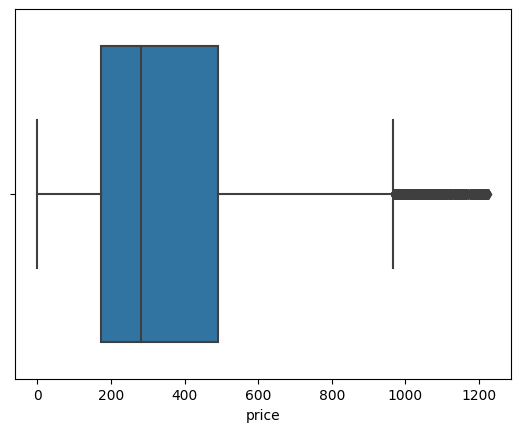

In [8]:
#showing on the box plot listings without extremely outliers price
sns.boxplot(data=df, x='price')

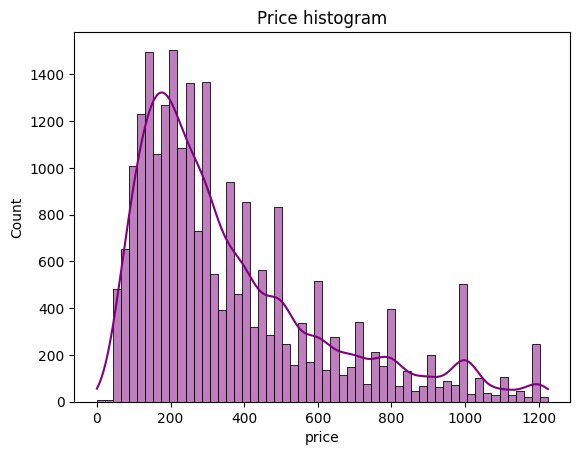

In [9]:
# price histogram without outliers to better compreesion of situation as a whole

sns.histplot(df['price'], color='purple', kde=True)
#bins = np.arange(0, df['price'].max(),50)
#plt.hist(data= df, x='price', bins=bins)
plt.title('Price histogram')
plt.show()

In [10]:
# create the variable price per accomodate
df['ppa'] = df['price']/df['accommodates']

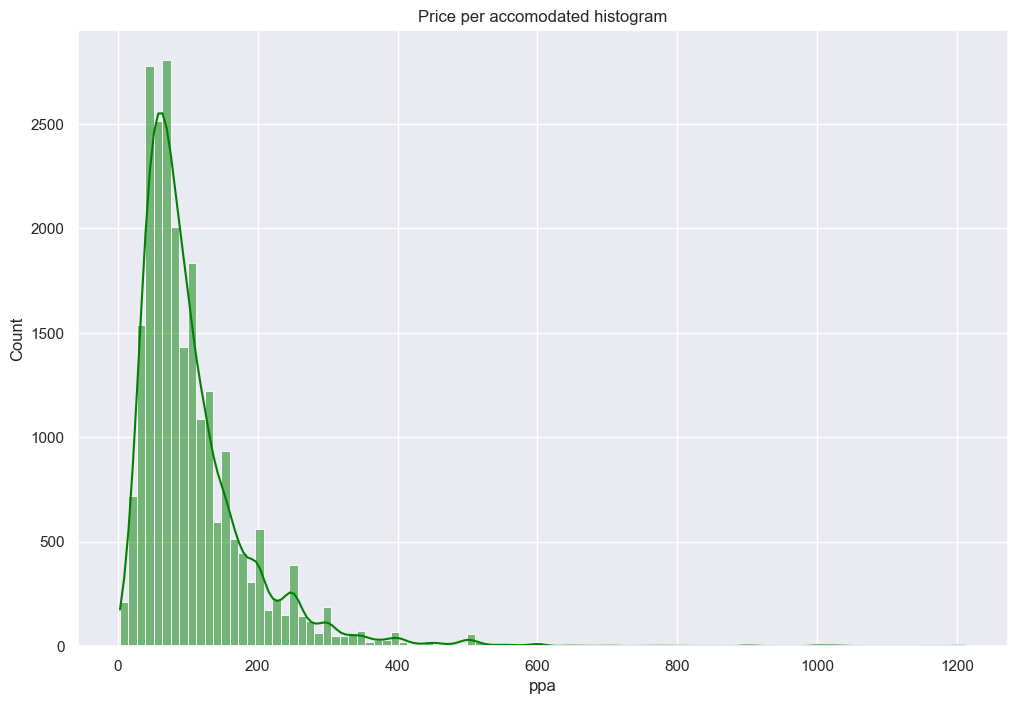

In [11]:
sns.set(rc={'figure.figsize':(12,8)})

sns.histplot(df['ppa'], color='green', bins=100, kde=True)
#bins = np.arange(0, df['price'].max(),50)
#plt.hist(data= df, x='price', bins=bins)
plt.title('Price per accomodated histogram')
plt.show()

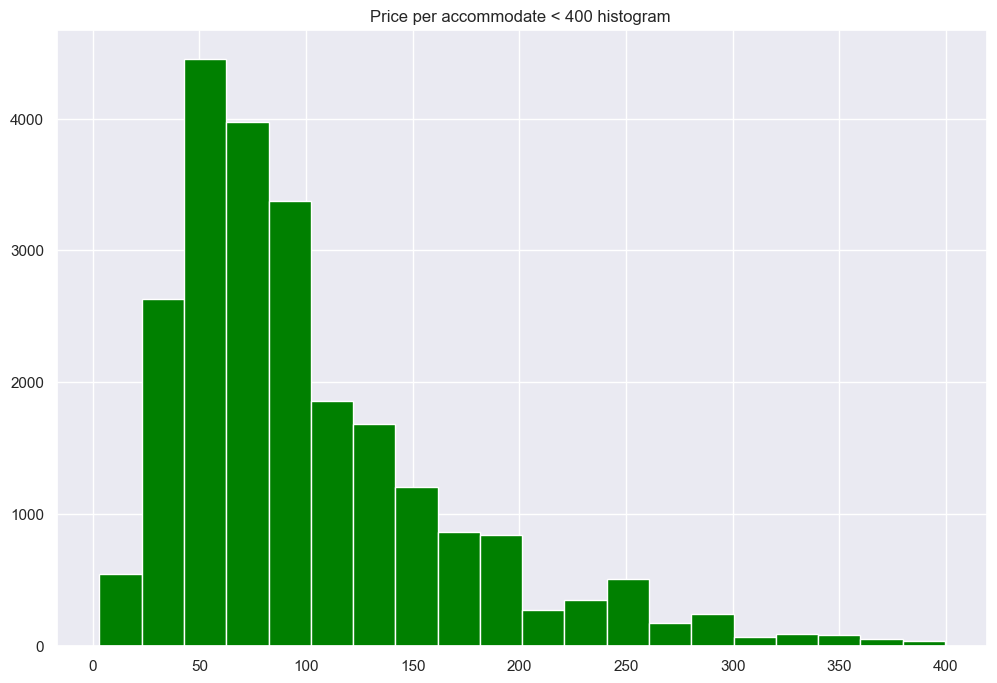

In [12]:
# price per accommodate histogram, considering only values under 300

#sns.histplot(df['ppa']<300['ppa'], color='purple', kde=True)
df[df['ppa']<400]['ppa'].hist(color='green', bins=20)
plt.title('Price per accommodate < 400 histogram ')
plt.show()

**Data Preparation - Listing dataset (df)**

In order to analyse the property size, we need to consider the property type, room type and badrooms features from data set.

We will further explore the above said feature and create a new dataframe.



In [13]:
# Fill NaN values with ffill/bfill since it is an object type and can't be interpreted with numerical methods to ffilna

df['host_response_rate'].fillna(method='backfill', inplace=True)
df['host_acceptance_rate'].fillna(method='backfill', inplace=True)
df['host_response_time'].fillna(method='backfill', inplace=True)

# Remove %sign and conver the data type to int

df['host_response_rate'] = (df['host_response_rate'].str[:-1].astype(int))
df['host_acceptance_rate'] = (df['host_acceptance_rate'].str[:-1].astype(int))

In [14]:
# Accordanly with summary of df, bathrooms was deleted because had all values NaN(null), but the correct information was placed in bethrooms_text that was 'object' type,
# for that we will rename the column bethrooms_text to bethrooms to better visualization, and than converte only the numbers to float

df.rename(columns={'bathrooms_text' : 'bathrooms'}, inplace=True)
df['bathrooms'] = df['bathrooms'].str.extract('(\d+)').astype(float)

df.bathrooms.head(3)

2    1.0
4    1.0
5    1.0
Name: bathrooms, dtype: float64

In [15]:
# As per summary of df, bathrooms, bedrooms and bed columns have different numbers of rows with null values, so it will be better to drop those null rows to avoid any little effect of bias, or missleading results.
#34  bathrooms      26289 non-null  float64
#35  bedrooms       25055 non-null  float64
#36  beds           26130 non-null  float64
# drop na rows in bathrooms, bedrooms and beds since they have differente numbers of rows with NaN(null) values
df.dropna(axis=0, subset=['bathrooms', 'bedrooms', 'beds'], inplace=True)

# Creating a new dataframe with bathrooms, bedrooms and beds.
df_rooms = df[['bathrooms', 'bedrooms', 'beds']]

# Converting the data type from string to integer
for room in df_rooms:
    df_rooms[room].astype(int)

#Assigning the converted values from df_rooms to the df_list dataframe
df[['bathrooms', 'bedrooms', 'beds']] = df_rooms[['bathrooms', 'bedrooms', 'beds']]


In [16]:

# Lets fill na with median values for reviews columns
#The review data distribution above show that the data is highly skewed to left
#To avoid bias in result due to skewness we chose mean to fill na instead of other methods 
for feature in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                "review_scores_value", "reviews_per_month"]:
    df[feature].fillna(df[feature].mean(), inplace = True)

**Data Preparation - Calendar data - df_cal**

In [17]:
# Extract month from dates column

df_cal['month'] = df_cal.date.apply(lambda value: value.split('-')[1])
df_cal['month'] = df_cal['month'].replace({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

# Removing adjusted_price column and using only price, to better formart the model, and trying to avoid confusions
# Remove special characters $ from price column and convert to float 
# Drop rows with NaN (null) value in price column, as we have enough rows of data to gain some confidance

df_cal.drop(axis=1, labels=['adjusted_price'], inplace=True)
df_cal.dropna(axis = 0, subset = ["price"], inplace = True)
df_cal["price"] = df_cal["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

df_cal.head()

,listing_id,date,available,price,minimum_nights,maximum_nights,month
0,53344884,2022-09-22,t,3500.0,3.0,365.0,Sep
1,53344884,2022-09-23,t,3500.0,3.0,365.0,Sep
2,53344884,2022-09-24,t,3500.0,3.0,365.0,Sep
3,53344884,2022-09-25,t,3500.0,3.0,365.0,Sep
4,53344884,2022-09-26,t,3500.0,3.0,365.0,Sep


**Numerical Features**

In [18]:
# select the numerical features 
df_int = df.select_dtypes(include=['float64', 'int64', 'int32'])

# add categorical columns to df_int 
df_int[['superhost', 'room_type', 'neighbourhood_cleansed', 'property_type', 'host_response_time']] = df[['host_is_superhost', 'room_type', 'neighbourhood_cleansed', 'property_type', 'host_response_time']]

#drop the columns which has large number of null values, which will be a hinder while applying prediction algorithms
df_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22153 entries, 2 to 26365
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            22153 non-null  int64  
 1   scrape_id                                     22153 non-null  int64  
 2   host_id                                       22153 non-null  int64  
 3   host_response_rate                            22153 non-null  int32  
 4   host_acceptance_rate                          22153 non-null  int32  
 5   host_listings_count                           22151 non-null  float64
 6   host_total_listings_count                     22151 non-null  float64
 7   latitude                                      22153 non-null  float64
 8   longitude                                     22153 non-null  float64
 9   accommodates                                  22153 non-null 

In [19]:
# percentage of null values per column in numerical variables
null_df_int = pd.DataFrame(df_int.isnull().sum()/df_int.shape[0]).reset_index()
null_df_int.columns = ['numerical features', '% of null values']
null_df_int = null_df_int.sort_values(by='% of null values', ascending=False)
null_df_int = null_df_int.reset_index(drop=True)
null_df_int

,numerical features,% of null values
0,host_listings_count,0.000090
1,host_total_listings_count,0.000090
2,superhost,0.000045
3,id,0.000000
4,review_scores_value,0.000000
5,number_of_reviews_ltm,0.000000
6,number_of_reviews_l30d,0.000000
7,review_scores_rating,0.000000
8,review_scores_accuracy,0.000000
9,review_scores_cleanliness,0.000000


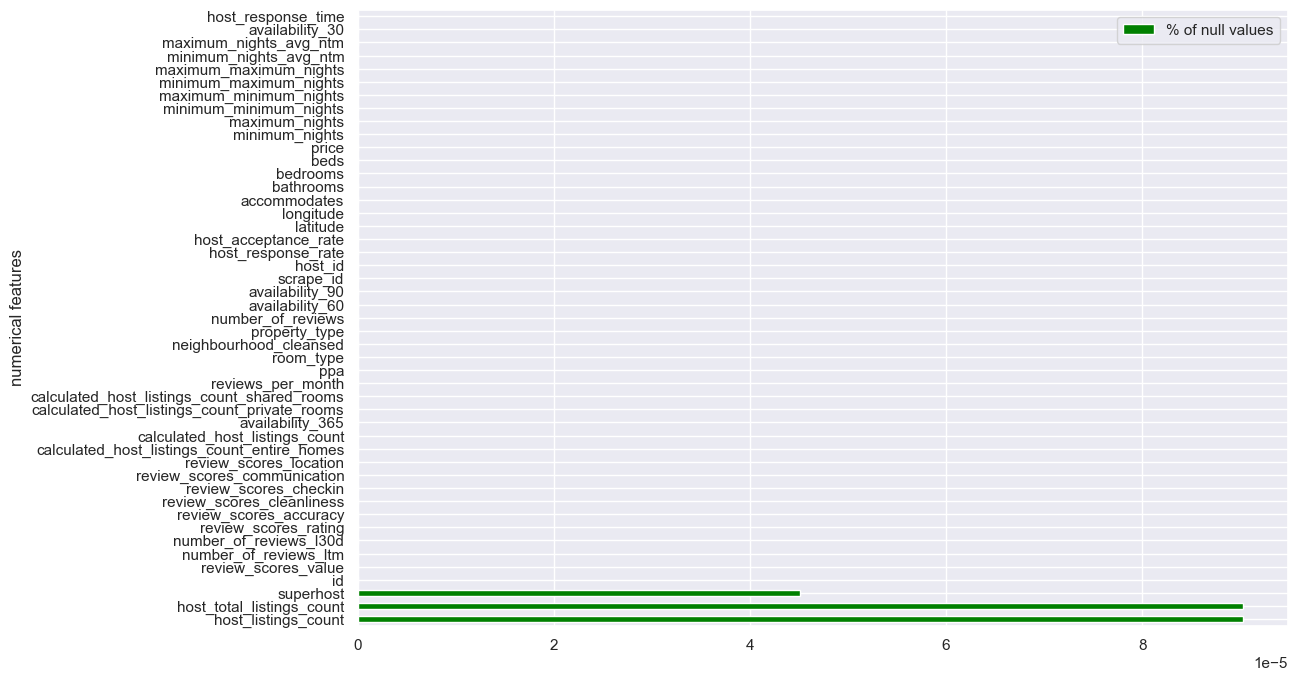

In [20]:
# plot % of null values in numercial variables
null_df_int.plot.barh(x='numerical features', y='% of null values', color='green')
plt.show()

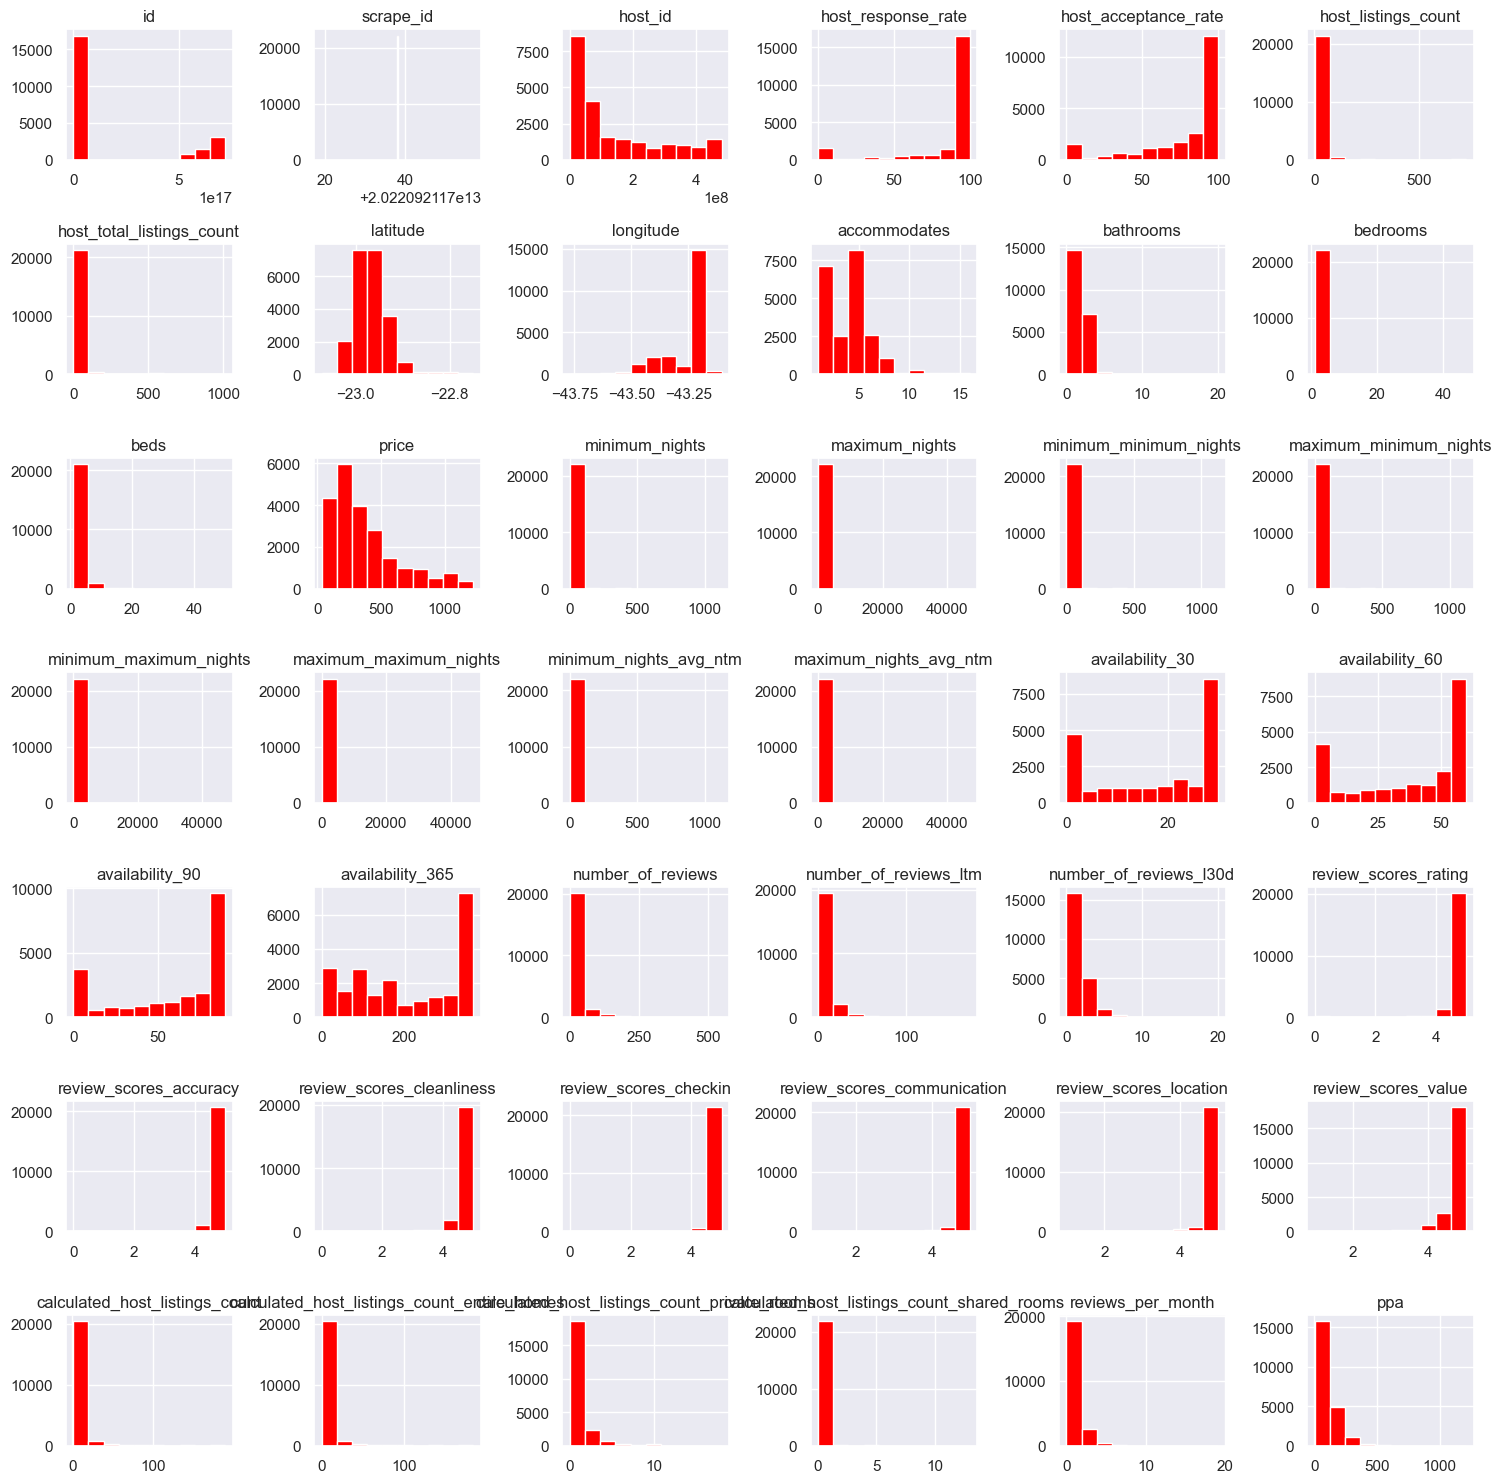

In [21]:
# histograms numerical variables
df_int.hist(figsize=(15, 15), color='red')
plt.tight_layout()


**CATEGORICAL FEATURES**

In [22]:
# select categorical features
cat = df.select_dtypes(exclude=['float64', 'int64', 'int32'])
cat.head(3)

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,...,neighbourhood,neighbourhood_cleansed,property_type,room_type,amenities,has_availability,calendar_last_scraped,first_review,last_review,instant_bookable
2,https://www.airbnb.com/rooms/14333905,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",NaN,https://a0.muscache.com/pictures/15235501-16c4...,https://www.airbnb.com/users/show/87749071,Lindenberg,2016-08-03,...,NaN,Pavuna,Entire home,Entire home/apt,"[""Cable TV"", ""Air conditioning"", ""Hair dryer"",...",t,2022-09-22,NaN,NaN,t
4,https://www.airbnb.com/rooms/35351763,2022-09-22,city scrape,Uma grande família,"Estou oferecendo minha casa ,minha família meu...",São Mateus,https://a0.muscache.com/pictures/44713611-925b...,https://www.airbnb.com/users/show/249666532,Jorgina,2019-03-18,...,"Parque Sao Nicolau, Rio de Janeiro, Brazil",Pavuna,Earthen home,Entire home/apt,"[""Air conditioning"", ""First aid kit"", ""Iron"", ...",t,2022-09-22,NaN,NaN,t
5,https://www.airbnb.com/rooms/53042498,2022-09-22,city scrape,Lindo e aconchegante FLAT.,Locação de lindo Flat espaçoso e moderno no Ce...,NaN,https://a0.muscache.com/pictures/f15af380-0979...,https://www.airbnb.com/users/show/390320631,Imobiliária,2021-02-27,...,NaN,Vigário Geral,Entire serviced apartment,Entire home/apt,"[""Dedicated workspace"", ""Essentials"", ""Microwa...",t,2022-09-22,2022-01-03,2022-06-12,t


In [23]:
# calculate the percentage of null values per column on categorical features
cat_null = pd.DataFrame(cat.isnull().sum()/cat.shape[0]).reset_index()
cat_null.columns = ['categorical features', '% of null values']
cat_null = cat_null.sort_values(by='% of null values', ascending=False)
cat_null = cat_null.reset_index(drop=True)
cat_null

,categorical features,% of null values
0,host_about,0.511172
1,neighbourhood,0.458222
2,neighborhood_overview,0.458222
3,host_neighbourhood,0.406943
4,first_review,0.227689
5,last_review,0.227689
6,host_location,0.178621
7,description,0.027987
8,name,0.000497
9,host_name,0.000090


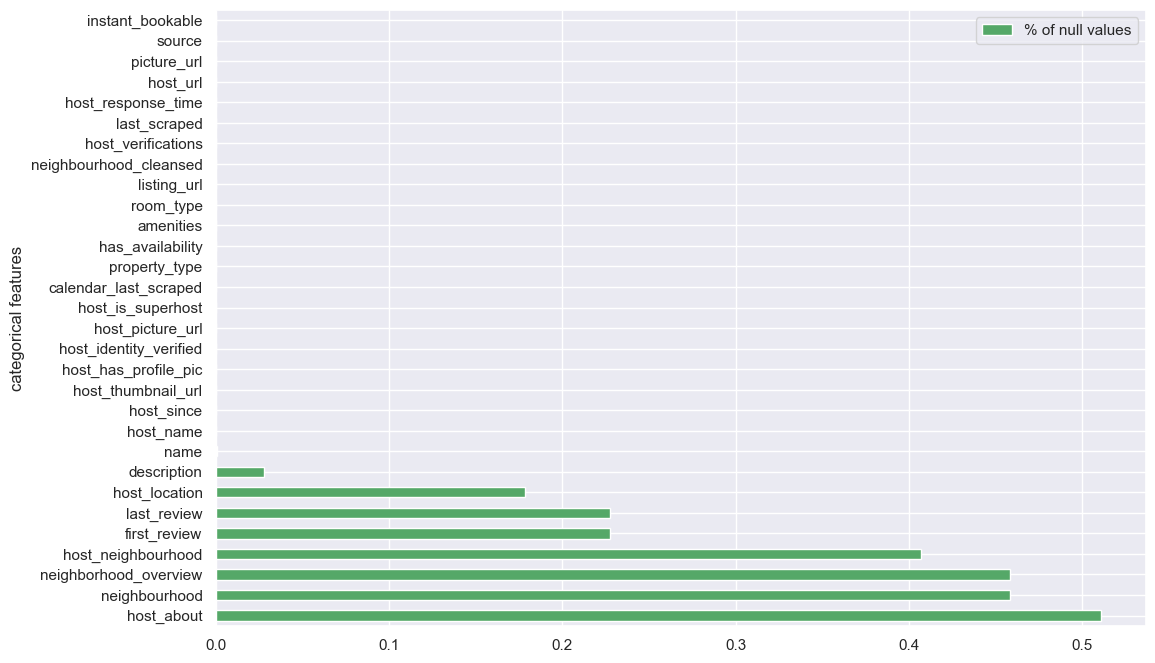

In [24]:
# plot of percentage of null values in categorical features
cat_null.plot.barh(x='categorical features', y='% of null values', color='g')
plt.show()

**AMENITIES**

In [26]:
df.amenities = df.amenities.str.replace("[{}]", "").str.replace('"', "")
df['amenities'].count()

C:\Users\zanin\AppData\Local\Temp\ipykernel_7316\1421940902.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.amenities = df.amenities.str.replace("[{}]", "").str.replace('"', "")


22153

In [28]:
#Handle Categorical Variable

cleanup_nums = {'superhost': {'t':1, 'f': 2},
'room_type': {'Entire home/apt': 1, 'private room': 2, 'shared room': 3}}
df_int_copy = df_int
df_int_copy = df_int_copy.replace(cleanup_nums)

#neighbourhood_cleansed, property_type, host_response_time 
df_int_dummies = pd.get_dummies(df_int_copy)
